# Imports

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

# DataSet

In [19]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df = df[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'text'})
df

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


#Explore The Data

In [ ]:
# Shape of the Dataset
print("Input data has {} rows and {} columns".format(len(df), len(df.columns)))

Input data has 5572 rows and 2 columns


In [ ]:
# How many Spam/ham in dataset

print("Out of {} rows, {} are spam, {} are ham".format(len(df), len(df[df['label']=='spam']), len(df[df['label']== 'ham'])))

Out of 5572 rows, 747 are spam, 4825 are ham


In [27]:
# Missing data

print ("Number of null in label: {}".format(df['label'].isnull().sum()))
print ("Number of null in label: {}".format(df['text'].isnull().sum()))

Number of null in label: 0
Number of null in label: 0


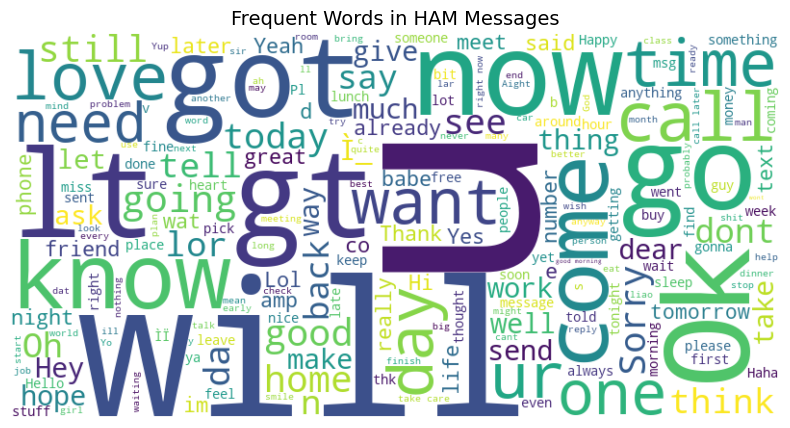

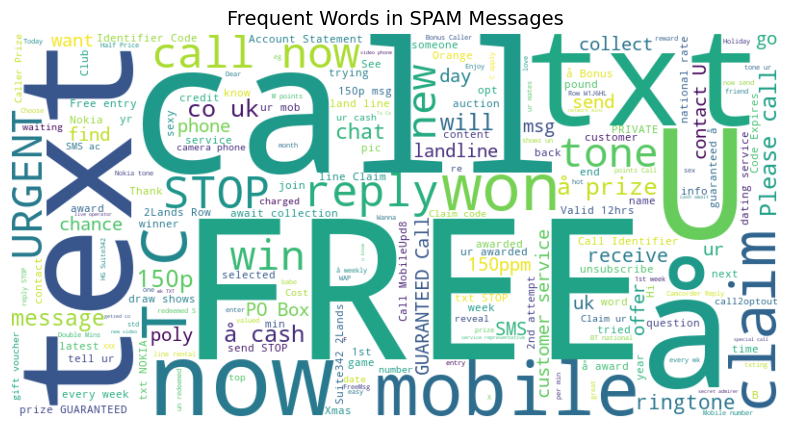

In [28]:


# Word clouds
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()

ham_text = " ".join(df[df['label'] == 'ham']['text'])
spam_text = " ".join(df[df['label'] == 'spam']['text'])
plot_wordcloud(ham_text, "Frequent Words in HAM Messages")
plot_wordcloud(spam_text, "Frequent Words in SPAM Messages")



# Text Processing

In [29]:
# Clean text
nltk.download('stopwords')
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['cleaned_text'] = df['text'].apply(clean_text)
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,text,cleaned_text
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st m...
3,ham,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though



    TF (Term Frequency): How often a word appears in a message.
    IDF (Inverse Document Frequency): Penalizes words common across all messages (e.g., "the").


In [34]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_text']).toarray()
y = df['label'].map({'ham': 0, 'spam': 1})

In [36]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Train Naive Bayes
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [38]:
# Predict
y_pred = model.predict(X_test)

In [41]:
# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.968609865470852
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.77      0.87       150

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.93      1115
weighted avg       0.97      0.97      0.97      1115



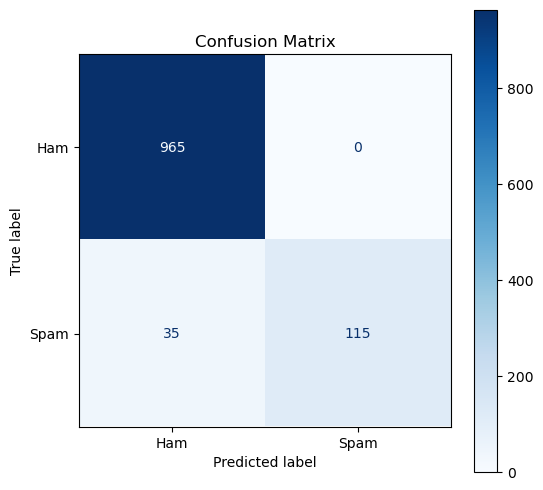

In [44]:
import matplotlib.pyplot as plt


# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a display object
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Ham', 'Spam'])

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


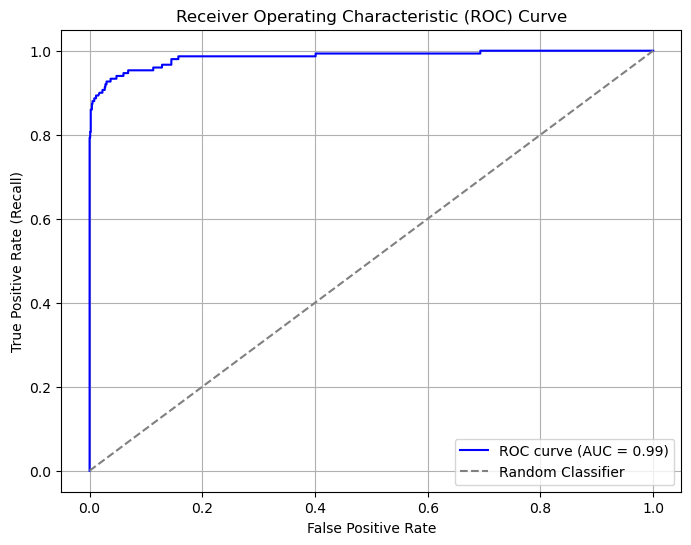

In [46]:
from sklearn.metrics import roc_curve, roc_auc_score

y_proba = model.predict_proba(X_test)[:, 1]

# Calculate FPR, TPR, and thresholds for ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
